# Training a Graph-structured GAN for Floor Plan Auto-Completion

## Imports and config

In [3]:
# general
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_snippets import subplots, print  # this overwrites the common print (!)
from omegaconf import OmegaConf

# own
from utils import load_pickle

# configurations
cfg = OmegaConf.load("config.yaml")
print(OmegaConf.to_yaml(cfg))

seed: 0
opt:
  optimizer: Adam
  momentum: 0.9
  weight_decay: 0.0001
  lr: 0.001
  betas: (0.5, 0.999)
model:
  name: tag_conv
  framework: gan
  noise_size: 128
  gen_hids_size: (64, 32, 32)
  gen_out_size: 5
  dis_hids_size: (64, 32, 16)
  n_critic: 5
  lambda_gp: 10
train:
  start_epoch: 0
  epochs: 50
  bs: 32
eval: null
dataset:
  path: C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge
  ratio: 0.8
  max_polygons: 30
  num_workers: 4
wandb:
  log: true
  dir: ./
  name: tag-conv-gan
  entity: casper-van-engelenburg
  project: floor-plan-auto-completion
misc: null

## Data factory

In [4]:
# set paths
path = {
    "full": cfg.dataset.path,
    "graph": os.path.join(cfg.dataset.path, 'train', 'graph_out'),
    "graph_simple": os.path.join(cfg.dataset.path, 'train', 'graph_simple')
}

# check path existence
_ = [print(f'{path[key]} exists: {os.path.exists(path[key])}') for key in path.keys()]

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge exists: True

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\train\graph_out exists:
True

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\train\graph_simple 
exists: True

### Change graphs to simple graphs / and filter on max polygons

In [3]:
# from tqdm.auto import tqdm
#
# # helper functions
# def get_max_size_polygon(areas):
#
#     max_points = 0
#     for area in areas:
#         temp_points = len(area)
#         if temp_points > max_points:
#             max_points = temp_points
#
#     return max_points
#
# # get polygon size distribution
# polygon_size_distribution = []
# for file in tqdm(os.listdir(path["graph"])):
#
#     # extract index from file
#     index = file[:-7]
#     graph_nx = load_pickle(os.path.join(path["graph"], f'{index}.pickle'))
#
#     # extract geometries
#     areas = [n for _, n in graph_nx.nodes(data="geometry")]
#
#     # get largest polygon
#     max_size = get_max_size_polygon(areas)
#     polygon_size_distribution.append(max_size)

In [4]:
# from collections import Counter, defaultdict
# import matplotlib.pyplot as plt
#
# # count polygon number
# count_df = dict(Counter(polygon_size_distribution))
# print(len(count_df.values()))
#
# # histogram
# fs = 10
# fig, ax = plt.subplots(1,1,figsize=(fs, fs))
#
# _ = plt.hist(count_df, bins=len(count_df.values()))
# # print(count_df.columns)
# # count_df = count_df.sort_values(by = )

### New data instances (room properties)

In [5]:
import networkx as nx
from shapely.geometry import Polygon, Point
import math
import numpy as np
from tqdm.auto import tqdm

def _azimuth(point1, point2):
    """azimuth between 2 points (interval 0 - 180)"""

    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180

def _dist(a, b):
    """distance between points"""

    return math.hypot(b[0] - a[0], b[1] - a[1])

def get_properties(polygon):
    """azimuth of minimum_rotated_rectangle"""

    xy = list(polygon.centroid.coords)[0]

    # extract bbox
    bbox = list(polygon.minimum_rotated_rectangle.exterior.coords)

    # determine width and height
    width = _dist(bbox[0], bbox[3])
    height = _dist(bbox[0], bbox[1])

    # determine area
    # area = width * height

    # to make consistent
    if width <= height:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])

    return torch.tensor([xy[0], xy[1], width, height, np.radians(az)])

# for file in tqdm(os.listdir(path["graph"])):
#
#     # extract index from file
#     index = file[:-7]
#     graph_nx = load_pickle(os.path.join(path["graph"], f'{index}.pickle'))
#
#     info_nodes = {}
#     for n, area in graph_nx.nodes(data="geometry"):
#
#         # convert to polygon
#         polygon = Polygon(area)
#
#         # get minimum rotated rectangle around it
#         info = get_properties(polygon)
#
#         # add information to dictionary
#         info_nodes[n] = {"properties": info}
#
#     # add information to graph and convert to pyg graph
#     graph_nx.add_nodes_from([(u, v) for u, v in info_nodes.items()])
#     graph_pyg = pyg.utils.from_networkx(graph_nx)
#
#     # delete unnecessary information
#     del graph_pyg.geometry
#     del graph_pyg.centroid
#     del graph_pyg.connectivity
#
#     torch.save(graph_pyg, os.path.join(path["graph_simple"], f'{index}'))

In [6]:
graph_pyg = torch.load(os.path.join(path["graph_simple"], f'{456}'))
print(graph_pyg)
print(graph_pyg.properties[1])

Data(edge_index=[2, 34], room_type=[18], properties=[18, 5], num_nodes=18)

tensor[5] f64 x∈[1.283, 5.750] μ=3.037 σ=1.737 [5.750, 3.545, 2.685, 1.920, 1.283]

### Plot graphs

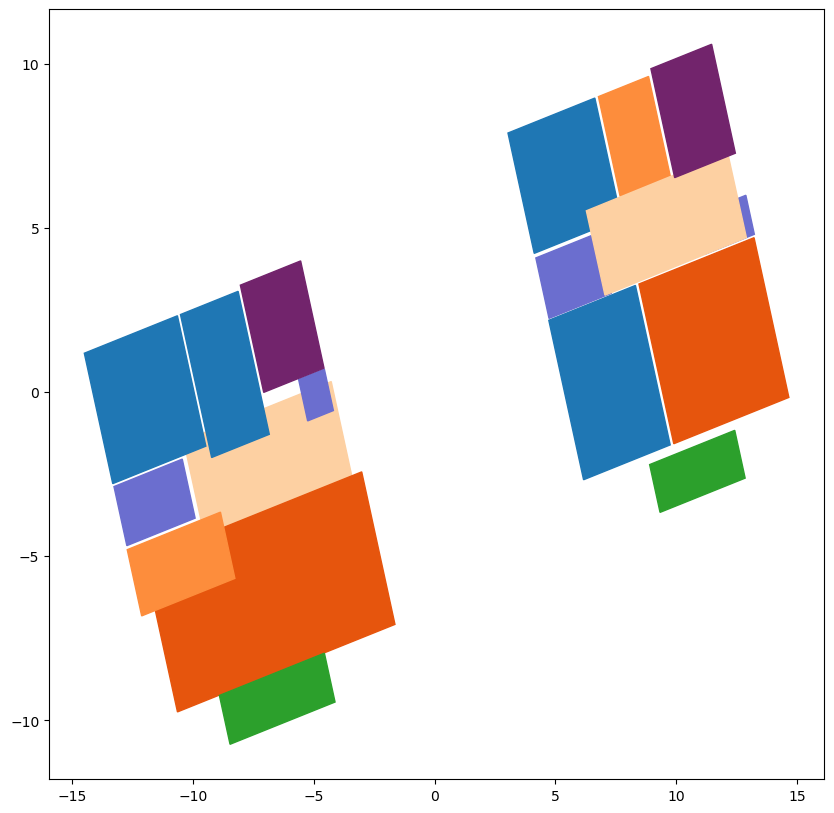

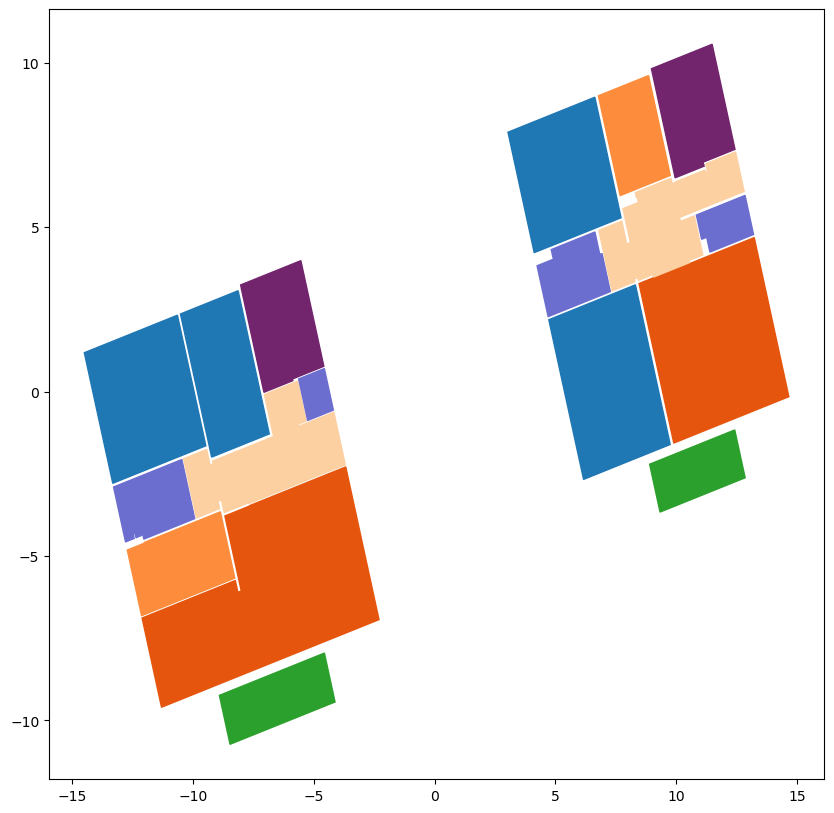

In [7]:
from shapely import affinity
from shapely.geometry import Polygon
from constants import CMAP_ROOMTYPE
from plot import plot_polygon

def info_to_geom(info):  # torch.tensor([xy[0], xy[1], width, height, np.radians(az)])

    c_x, c_y, w, h, rot = info
    xmin = c_x - 1/2 * w
    xmax = c_x + 1/2 * w
    ymin = c_y - 1/2 * h
    ymax = c_y + 1/2 * h

    diff_x = xmax - xmin
    diff_y = ymax - ymin

    rect = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])
    if diff_x < diff_y:
        rot_rect = affinity.rotate(rect, np.degrees(-rot), 'center')
    else:
        rot_rect = affinity.rotate(rect, np.degrees(-rot) + 90, 'center')

    return rot_rect

graph_pyg = torch.load(os.path.join(path["graph_simple"], f'{456}'))

# set up figure
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))

for info, roomtype in zip(graph_pyg.properties, graph_pyg.room_type):

    geom = info_to_geom(info)

    c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
    plot_polygon(ax, geom, fc=c, ec=c, label=c)


graph_nx = load_pickle(os.path.join(path["graph"], f'{456}.pickle'))
graph_pyg = pyg.utils.from_networkx(graph_nx)

# set up figure
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))

for geom, roomtype in zip(graph_pyg.geometry, graph_pyg.room_type):

    geom = Polygon(geom)

    c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
    plot_polygon(ax, geom, fc=c, ec=c, label=c)

### Develop custom graph dataset / dataloader

In [8]:
# import random
# from utils import save_pickle
#
# # size of full dataset
# N = len(os.listdir(path["graph_simple"]))
# ids = np.arange(0, N-1)
#
# # randomly shuffle ids
# random.Random(4).shuffle(ids)
#
# # split training and test
# split = 0.75
# N_train = int(split*N)
#
# print(f"Total:\t{N}")
# print(f'Samples:\n\ttrain:\t{N_train}\n\tval:\t{N - N_train}')
#
# split = {
#     "train": np.sort(ids[:N_train]),
#     "test": np.sort(ids[N_train:])
# }
#
# save_pickle(split, './split.pickle')

In [8]:
from constants import COLORS_ROOMTYPE
import torch.nn.functional as F

class GraphDataset(torch.utils.data.Dataset):
    """
    Graph Dataset. Collects NetworkX graph from a pre-defined folder and
    transforms them to Pytorch Geometric (pyg.data.Data()) instances.
    """
    def __init__(self, path, mode='train'):
        self.graph_path = path["graph_simple"]
        self.ids = load_pickle('split.pickle')[mode]

        # include graph transformations if you like
        # self.graph_transform = graph_transform

    def __getitem__(self, index):

        # get correct identity
        id = self.ids[index]

        # get access graph (name is index)
        graph = torch.load(os.path.join(self.graph_path, f'{id}'))

        # make one hot vectors from room categories
        graph.category = F.one_hot(graph.room_type, num_classes=len(COLORS_ROOMTYPE))

        del graph.room_type

        # add floor plan index as graph-level attribute
        graph.index = id

        # transform graph if you like
        # graph_pyg = self.graph_transform(graph_pyg)

        return graph

    def __len__(self):
        return len(self.ids)

In [9]:
bs = 64
dataset = GraphDataset(path, mode='train')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [10]:
dataiter = iter(dataloader)
batch = next(dataiter)
print(batch)

DataBatch(edge_index=[2, 4218], properties=[2095, 5], num_nodes=2095, category=[2095, 13], index=[64], 
batch=[2095], ptr=[65])

## Training

### Set up model

Define Generator and Discriminator classes.

In [11]:
import torch.nn as nn
from torch_geometric.nn import TAGConv, global_add_pool

class Generator(nn.Module):

    """
    WGAN-GP Generator

    Goal: make Discriminator maximize its output (score)
    """

    def __init__(self, input_dim, output_dim, hidden_dims=[64, 32, 16]):
        """
        input_dim:
        outpit_dim:
        """
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout_rate = 0.1

        # network layers; initial list
        self.module_list = nn.ModuleList()

        # input layer:
        self.module_list.append(TAGConv(input_dim, hidden_dims[0]))

        # intermediate layers; gradually add layers
        for i in range(1, len(hidden_dims)):
            layer = TAGConv(hidden_dims[i - 1], hidden_dims[i])
            self.module_list.append(layer)

        # Output layers
        self.module_list.append(TAGConv(hidden_dims[-1], output_dim))


    def forward(self, edge_index, x):

        # forward through modules in module list
        for module in self.module_list:
            x = module(x=x, edge_index=edge_index)
            x = nn.Dropout(self.dropout_rate, inplace=False)(x)
            x = nn.PReLU()(x)

        return x


class Discriminator(nn.Module):
    """
    WGAN-GP Discriminator
    Goal: minimize critic score for real samples
          maximize critic score for generator samples
    """
    def __init__(self, input_dim, hidden_dims=[16, 32, 64]):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = 0.1
        self.act = nn.Sigmoid()

        # scalar value (score) indicating how real the input is
        # in WGAN-GP we don't use sigmoid to turn it into a probability
        self.output_dim = 1

        # network layers; initial list
        self.module_list = nn.ModuleList()

        # input layer
        self.module_list.append(TAGConv(input_dim, hidden_dims[0]))

        # intermediate layers
        for i in range(1, len(hidden_dims)):
            layer = TAGConv(hidden_dims[i - 1], hidden_dims[i])
            self.module_list.append(layer)

        # output layer
        output_layer = nn.Linear(hidden_dims[-1], 1)
        self.module_list.append(output_layer)


    def forward(self, edge_index, x, batch):

        # loop through modules of module list
        for i in range(len(self.module_list) - 1):
            x = self.module_list[i](x=x , edge_index=edge_index)
            x = nn.Dropout(self.dropout_rate, inplace=False)(x)
            x = nn.PReLU()(x)

        # Pool graph node features; only add when coming from the same data instance
        x = global_add_pool(x, batch)

        # Predict WGAN score
        x = self.module_list[-1](x)
        # x = self.act(x)

        return x

In [33]:
def gradient_penalty(discriminator, edge_index, x_dr, x_df, batch):

    assert x_dr.shape == x_df.shape, "real and fake geometry shapes dont match"

    x_dr.requires_grad = True
    #fake.geometry.requires_grad = True

    # Construct interpolated geometry/features and compute score
    N, F = x_df.shape
    alpha = torch.rand((N, 1)).repeat(1, F)
    x_interpolated = alpha * x_dr + (1 - alpha) * x_df
    #interpolated_geometry.requires_grad = True

    interpolation_score = discriminator(edge_index, x_interpolated, batch)

    # Compute gradient of interpolated score wrt interpolated features
    # Note that (inputs, outputs) linked through a function above (discriminator is our function in this case)
    gradient = torch.autograd.grad(
        inputs=x_interpolated,                            # what we compute the gradients wrt to
        outputs=interpolation_score,                             # output we want gradients of
        grad_outputs=torch.ones_like(interpolation_score),
        create_graph=True,
        retain_graph=True
    )[0]

    # Change shape so we can compute penalty over the non batch dimension
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=-1)

    # (norm - 1) ** 2 enforces 1 lipschitz continutiy as we aim for this value to be as small as possible (0)
    # which is only achieved when the gradient_norm = 1
    return ((gradient_norm - 1 ) ** 2).mean()


def polygon_penalty(real_geometry, fake_geometry, alpha=0.1):  #TODO: what is alpha?
    """
    Compute a penalty based on MSE distance between the real and the fake geometry coordinates
    """

    # MSE distance between real and fake
    polygon_similarity = ((real_geometry - fake_geometry) ** 2).mean()

    # TODO: Penalty for more polygons in fake compared to real data?

    return polygon_similarity

In [12]:
generator = Generator(
    input_dim = cfg.model.noise_size + len(COLORS_ROOMTYPE),
    output_dim = cfg.model.gen_out_size,
    hidden_dims = [64, 32, 16]
)

# generator = Generator(
#     input_dim = len(COLORS_ROOMTYPE),
#     output_dim = cfg.model.gen_out_size,
#     hidden_dims = [64, 32, 16]
# )

discriminator = Discriminator(
    input_dim = cfg.model.gen_out_size,
    hidden_dims = [16, 32, 64]
)

print(generator.module_list)
print(discriminator.module_list)

ModuleList(
  (0): TAGConv(141, 64, K=3)
  (1): TAGConv(64, 32, K=3)
  (2): TAGConv(32, 16, K=3)
  (3): TAGConv(16, 5, K=3)
)

ModuleList(
  (0): TAGConv(5, 16, K=3)
  (1): TAGConv(16, 32, K=3)
  (2): TAGConv(32, 64, K=3)
  (3): Linear(in_features=64, out_features=1, bias=True)
)

### Optimizer and objective

In [15]:
from torch.nn import MSELoss

# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))

# Loss instantiation
mse_loss = MSELoss()

### Run

In [36]:
import time
from tqdm.auto import tqdm
from torch.nn import MSELoss

bs = 64
dataset = GraphDataset(path, mode='train')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

cfg.model.gen_out_size = 2

generator = Generator(
    input_dim = cfg.model.noise_size + len(COLORS_ROOMTYPE),
    output_dim = cfg.model.gen_out_size,
    hidden_dims = [64, 32, 16]
)

discriminator = Discriminator(
    input_dim = cfg.model.gen_out_size,
    hidden_dims = [16, 32, 64]
)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))

mse_loss = MSELoss()

num_steps = 0
start_time = time.time()

for epoch in range(cfg.train.epochs):

    losses_d = []
    losses_g = []

    for data in tqdm(dataloader, total=len(dataloader)):
        num_steps += 1

        # get and define sources of information
        x_dr = data.properties.float()[:, :cfg.model.gen_out_size]
        edge_index = data.edge_index
        category = data.category
        # print(category.shape, len(COLORS_ROOMTYPE))
        batch = data.batch

        # add noise and create x for generator
        noise = torch.randn((category.shape[0], cfg.model.noise_size))
        x_g = torch.concat((category, noise), dim=1)

        # feedforward through generator and create fake input for discriminator
        x_df = generator(edge_index, x_g)

        discriminator_fake = discriminator(edge_index, x_df.detach(), batch)    # discriminator scores for fakes
        discriminator_real = discriminator(edge_index, x_dr, batch)    # discriminator scores for reals

        gp = gradient_penalty(discriminator, edge_index, x_dr, x_df.detach(), batch)

        # Discriminator loss and train
        loss_discriminator = discriminator_fake.mean() - discriminator_real.mean() + cfg.model.lambda_gp * gp

        # Set gradients to zero
        #discriminator.zero_grad()
        optimizer_d.zero_grad()

        # Backprop and move
        loss_discriminator.backward()
        optimizer_d.step()

        losses_d.append(loss_discriminator.item())

        # Only train Generator every 5 steps
        if num_steps % cfg.model.n_critic == 0:

            # develop new sample
            x_df = generator(edge_index, x_g)
            discriminator_fake = discriminator(edge_index, x_df, batch)

            # loss of generator
            loss_generator = mse_loss(x_dr, x_df) - discriminator_fake.reshape(-1).mean()

            # Set gradients to zero
            # generator.zero_grad()
            optimizer_g.zero_grad()

            # Backprop and move
            loss_generator.backward()
            optimizer_g.step()

            losses_g.append(loss_generator.item())

    # 49 is just a temporary number
    epoch_time = time.time() - start_time
    start_time = time.time()
    print("Epoch {} took {:.2f} seconds.\n"
          "Loss (GEN / DIS): {:.2f} / {:.2f}".format(epoch, epoch_time, np.mean(losses_g), np.mean(losses_d)))

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 0 took 13.56 seconds.
Loss (GEN / DIS): -164.07 / -1494.52

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1 took 13.44 seconds.
Loss (GEN / DIS): 99.94 / -2778.58

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2 took 13.31 seconds.
Loss (GEN / DIS): 11.71 / -2641.96

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3 took 13.80 seconds.
Loss (GEN / DIS): -84.49 / -2380.16

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4 took 12.89 seconds.
Loss (GEN / DIS): 35.68 / -2511.41

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5 took 11.95 seconds.
Loss (GEN / DIS): 40.67 / -2686.36

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6 took 11.37 seconds.
Loss (GEN / DIS): -310.20 / -2218.71

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7 took 11.65 seconds.
Loss (GEN / DIS): -339.69 / -1427.28

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8 took 11.75 seconds.
Loss (GEN / DIS): -99.49 / -1336.00

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9 took 11.35 seconds.
Loss (GEN / DIS): -229.94 / -649.12

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10 took 11.39 seconds.
Loss (GEN / DIS): 256.48 / -921.18

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11 took 11.31 seconds.
Loss (GEN / DIS): -222.03 / -1087.19

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12 took 11.30 seconds.
Loss (GEN / DIS): -53.72 / -586.33

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13 took 12.04 seconds.
Loss (GEN / DIS): -159.13 / -510.59

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14 took 11.70 seconds.
Loss (GEN / DIS): -121.89 / -391.25

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15 took 12.31 seconds.
Loss (GEN / DIS): -118.31 / -271.83

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16 took 12.19 seconds.
Loss (GEN / DIS): 160.53 / -260.28

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17 took 12.71 seconds.
Loss (GEN / DIS): -35.77 / -269.66

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18 took 13.03 seconds.
Loss (GEN / DIS): 65.55 / -275.03

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19 took 17.38 seconds.
Loss (GEN / DIS): -13.92 / -266.12

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20 took 14.92 seconds.
Loss (GEN / DIS): 22.28 / -268.46

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21 took 12.24 seconds.
Loss (GEN / DIS): -29.36 / -294.57

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22 took 15.18 seconds.
Loss (GEN / DIS): 84.02 / -239.15

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23 took 16.26 seconds.
Loss (GEN / DIS): 39.64 / -276.03

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24 took 16.99 seconds.
Loss (GEN / DIS): 119.11 / -266.37

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25 took 12.92 seconds.
Loss (GEN / DIS): 88.84 / -258.01

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26 took 14.08 seconds.
Loss (GEN / DIS): -68.31 / -276.28

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27 took 12.89 seconds.
Loss (GEN / DIS): -7.92 / -258.68

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28 took 12.61 seconds.
Loss (GEN / DIS): 148.50 / -243.16

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29 took 11.84 seconds.
Loss (GEN / DIS): 4.01 / -243.05

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30 took 12.31 seconds.
Loss (GEN / DIS): 114.08 / -249.93

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 31 took 12.00 seconds.
Loss (GEN / DIS): -189.50 / -245.30

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 32 took 12.41 seconds.
Loss (GEN / DIS): 97.10 / -212.74

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 33 took 13.95 seconds.
Loss (GEN / DIS): -62.84 / -211.13

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 34 took 12.23 seconds.
Loss (GEN / DIS): -21.65 / -228.82

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 35 took 12.03 seconds.
Loss (GEN / DIS): 181.46 / -198.55

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 36 took 12.49 seconds.
Loss (GEN / DIS): 16.02 / -189.16

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 37 took 12.45 seconds.
Loss (GEN / DIS): 69.35 / -191.24

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 38 took 12.22 seconds.
Loss (GEN / DIS): 83.73 / -206.26

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 39 took 11.86 seconds.
Loss (GEN / DIS): 88.47 / -203.73

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 40 took 11.92 seconds.
Loss (GEN / DIS): 84.33 / -186.50

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 41 took 11.87 seconds.
Loss (GEN / DIS): 64.12 / -195.74

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 42 took 11.67 seconds.
Loss (GEN / DIS): 177.74 / -216.85

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 43 took 12.41 seconds.
Loss (GEN / DIS): 53.86 / -189.82

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 44 took 11.90 seconds.
Loss (GEN / DIS): 150.31 / -191.40

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 45 took 12.50 seconds.
Loss (GEN / DIS): 90.78 / -210.59

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 46 took 12.29 seconds.
Loss (GEN / DIS): 248.18 / -196.60

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 47 took 12.49 seconds.
Loss (GEN / DIS): 73.97 / -211.91

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 48 took 12.20 seconds.
Loss (GEN / DIS): 258.65 / -213.38

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 49 took 12.53 seconds.
Loss (GEN / DIS): 65.78 / -213.87

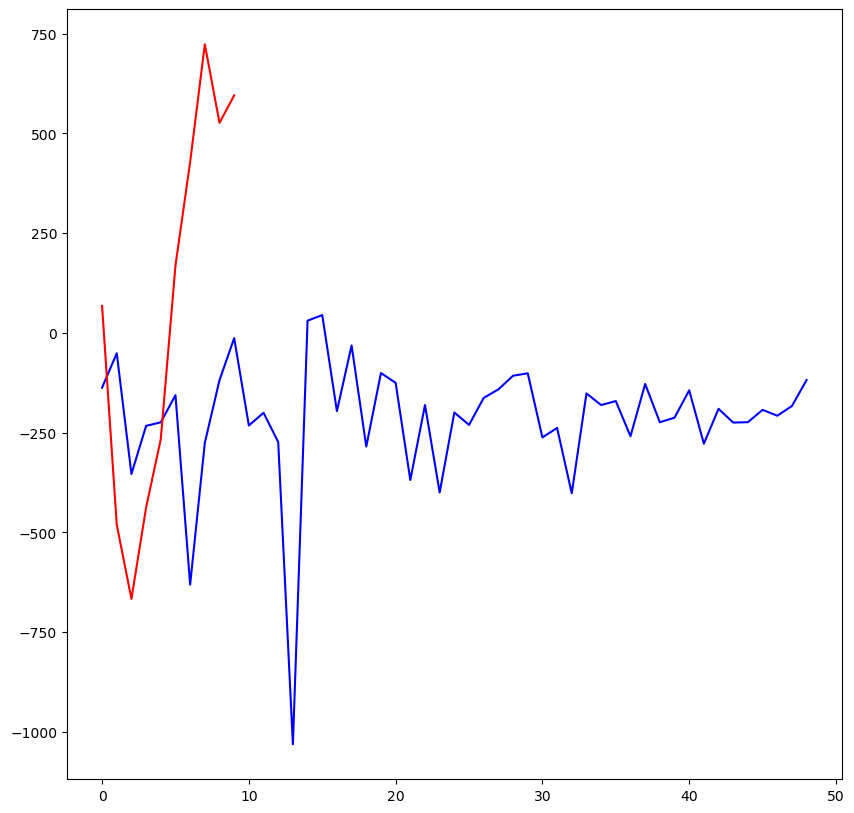

In [59]:
fig, ax = plt.subplots(1,1, figsize=(fs, fs))

ax.plot(losses_d, 'blue')
ax.plot(losses_g, 'red')

In [46]:
generator_path = './saved_models/generator_simple.pt'
discriminator_path = './saved_models/discriminator_simple.pt'
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

In [14]:
generator.load_state_dict(torch.load('./saved_models/generator_simple.pt'))
discriminator.load_state_dict(torch.load('./saved_models/discriminator_simple.pt'))

<All keys matched successfully>

In [28]:
bs = 9
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

# get and define sources of information
x_dr = data.properties.float()
edge_index = data.edge_index
category = data.category
# print(category.shape, len(COLORS_ROOMTYPE))
batch = data.batch
indices = data.index
print(indices)

# add noise and create x for generator
noise = torch.randn((category.shape[0], cfg.model.noise_size))
x_g = torch.concat((category, noise), dim=1)

# feedforward through generator and create fake input for discriminator
x_df = generator(edge_index, x_g).detach()

[2143, 2763, 712, 4122, 2433, 137, 952, 4001, 3162]

In [20]:
print(x_df[batch == 0, :])

tensor[62, 5] n=310 (1.2Kb) x∈[-44.873, 13.569] μ=1.107 σ=6.224

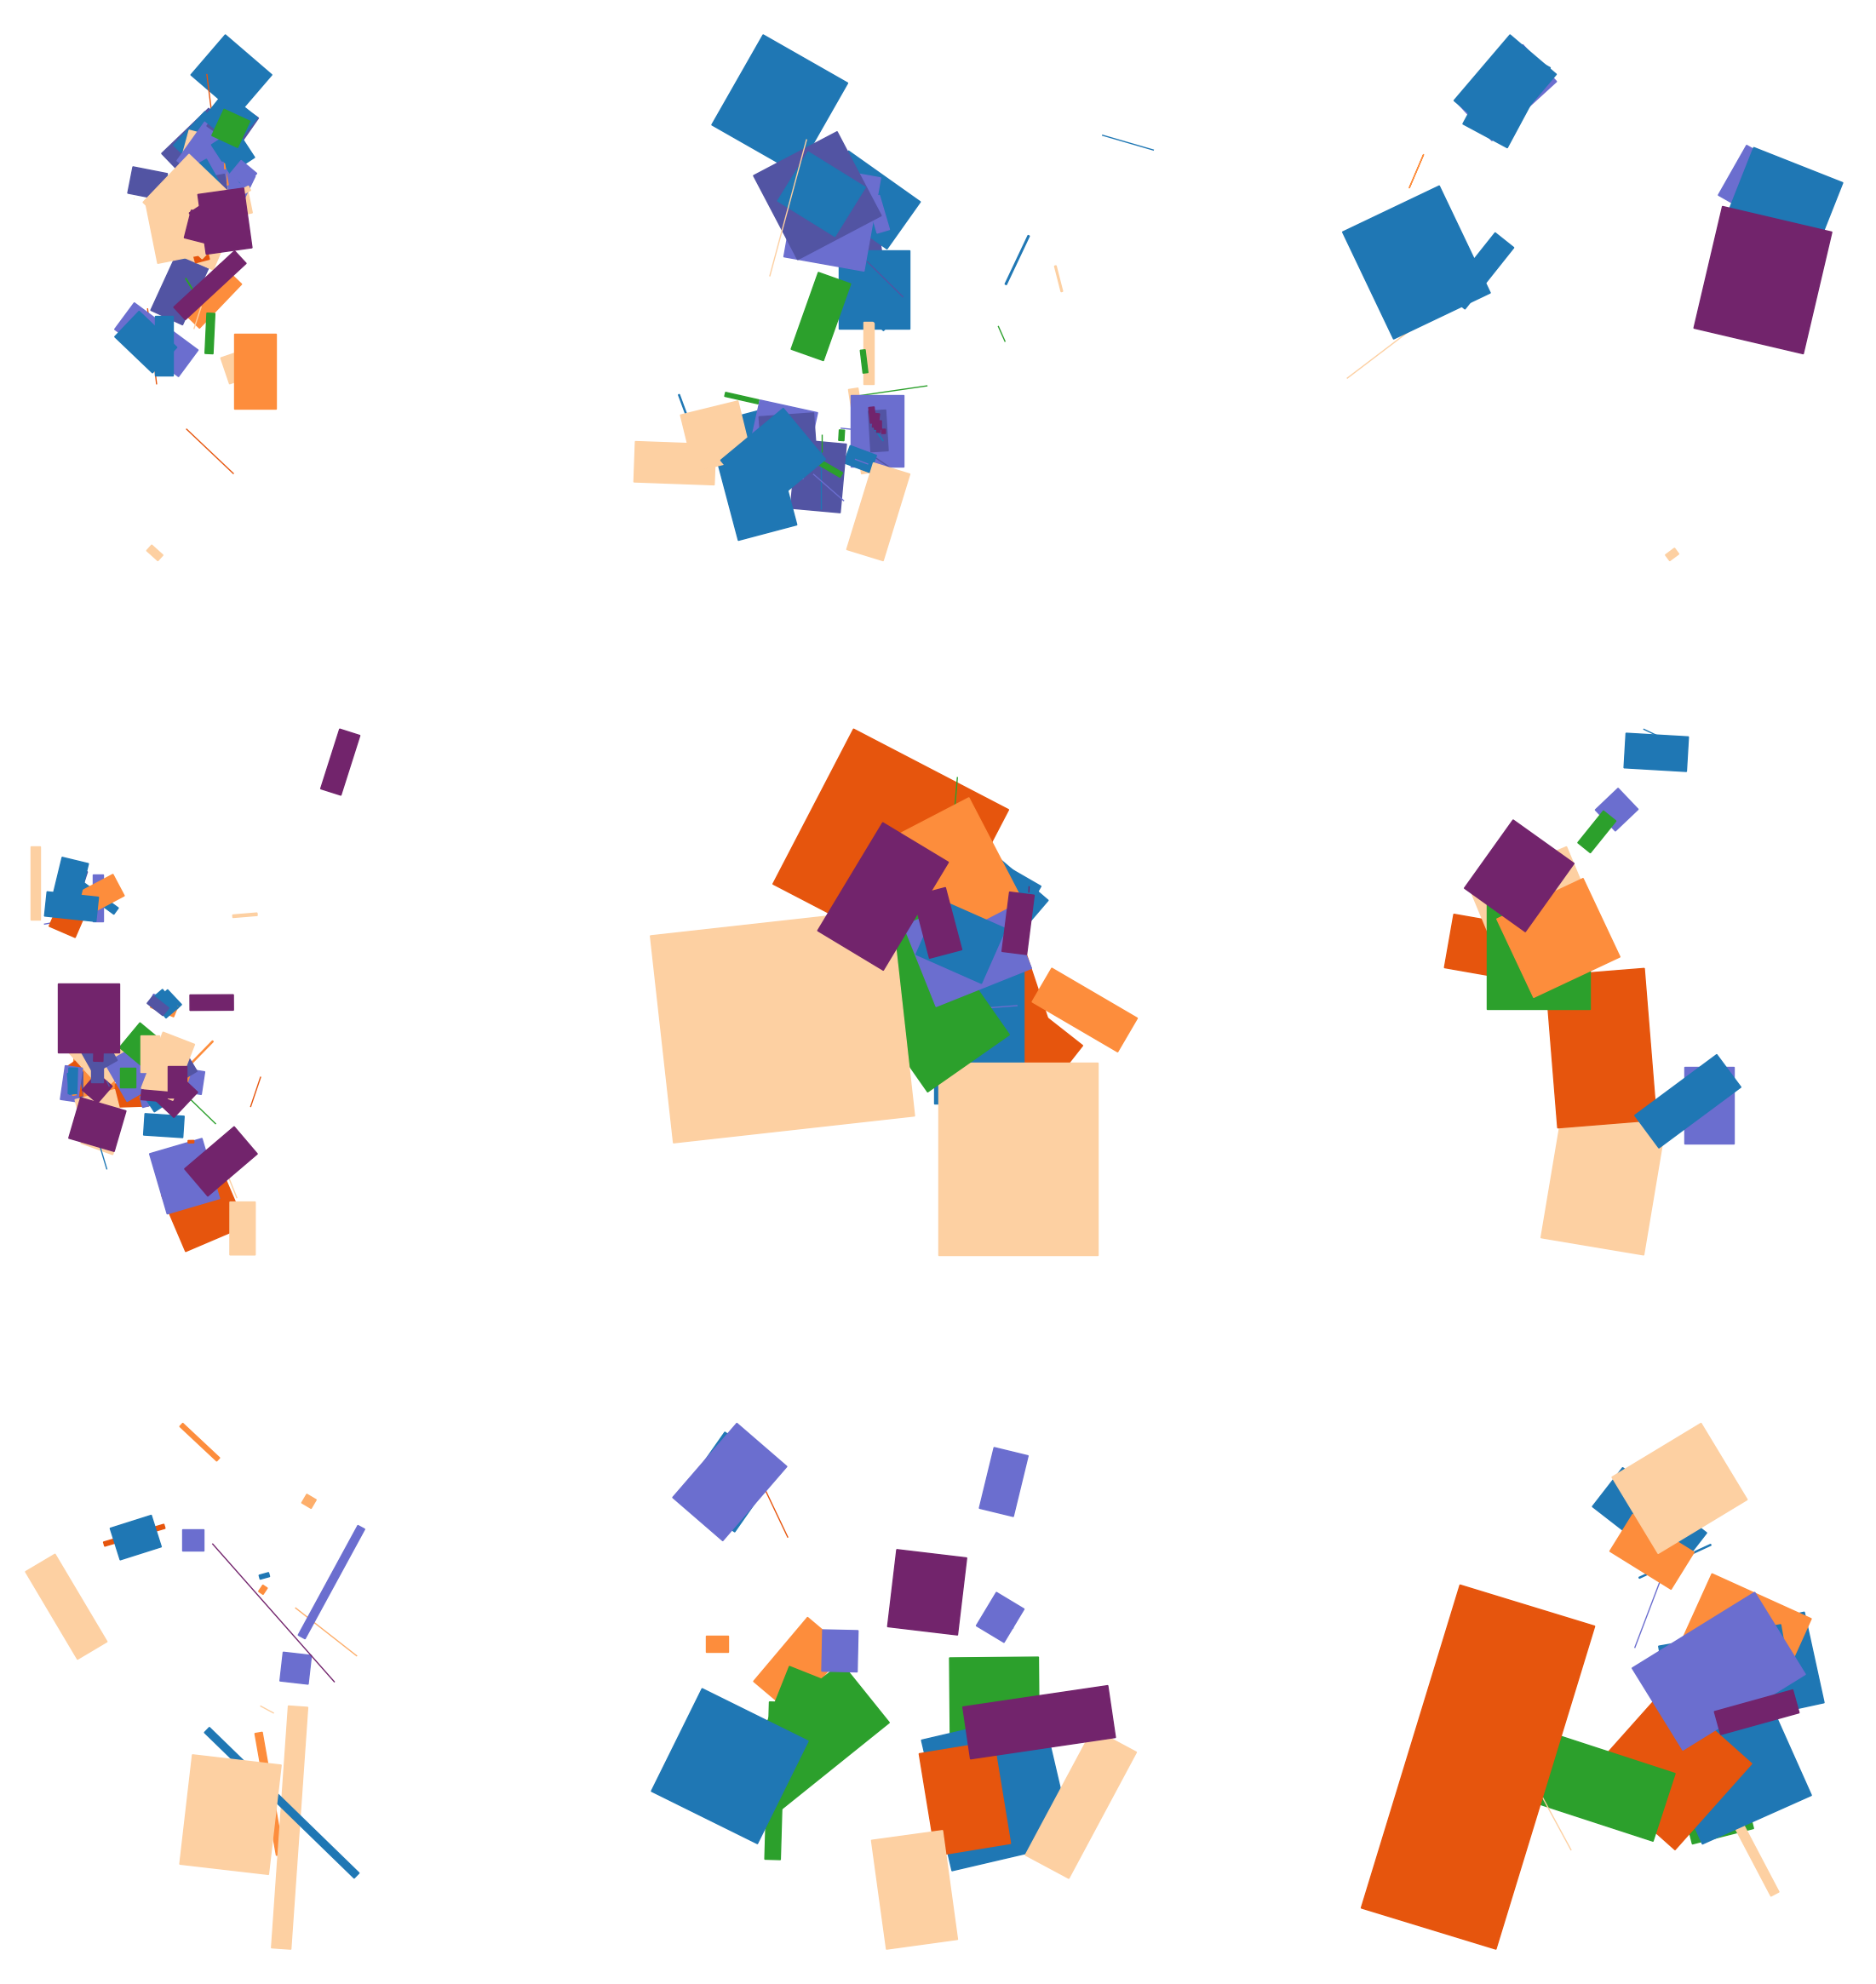

In [25]:
# set up figure
n = int(np.ceil(np.sqrt(bs)))
fs = 10
fig, axs = plt.subplots(n, n, figsize=(n*fs, n*fs))
axs = axs.flatten()

for i, ax in enumerate(axs):

    if i == bs: break
    for info, roomtype in zip(x_df[batch == i, :], category[batch == i, :]):

        roomtype = torch.argmax(roomtype)
        geom = info_to_geom(info)

        c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
        plot_polygon(ax, geom, fc=c, ec=c, label=c)

        _ = [ax.set_aspect('equal'), ax.axis('off')]

In [51]:
bs = 9
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

# get and define sources of information
x_dr = data.properties.float()
edge_index = data.edge_index
category = data.category
# print(category.shape, len(COLORS_ROOMTYPE))
batch = data.batch
indices = data.index

# add noise and create x for generator
noise = torch.randn((category.shape[0], cfg.model.noise_size))
x_g = torch.concat((category, noise), dim=1)

# feedforward through generator and create fake input for discriminator
x_df = generator(edge_index, x_g).detach()
print(x_df)

tensor[292, 2] n=584 (2.3Kb) x∈[-24.171, 25.327] μ=0.680 σ=7.755

In [52]:
data_nx = pyg.utils.to_networkx(data, node_attrs=["properties", "category", "batch"], to_undirected=True)
print(data_nx)

Graph with 292 nodes and 298 edges

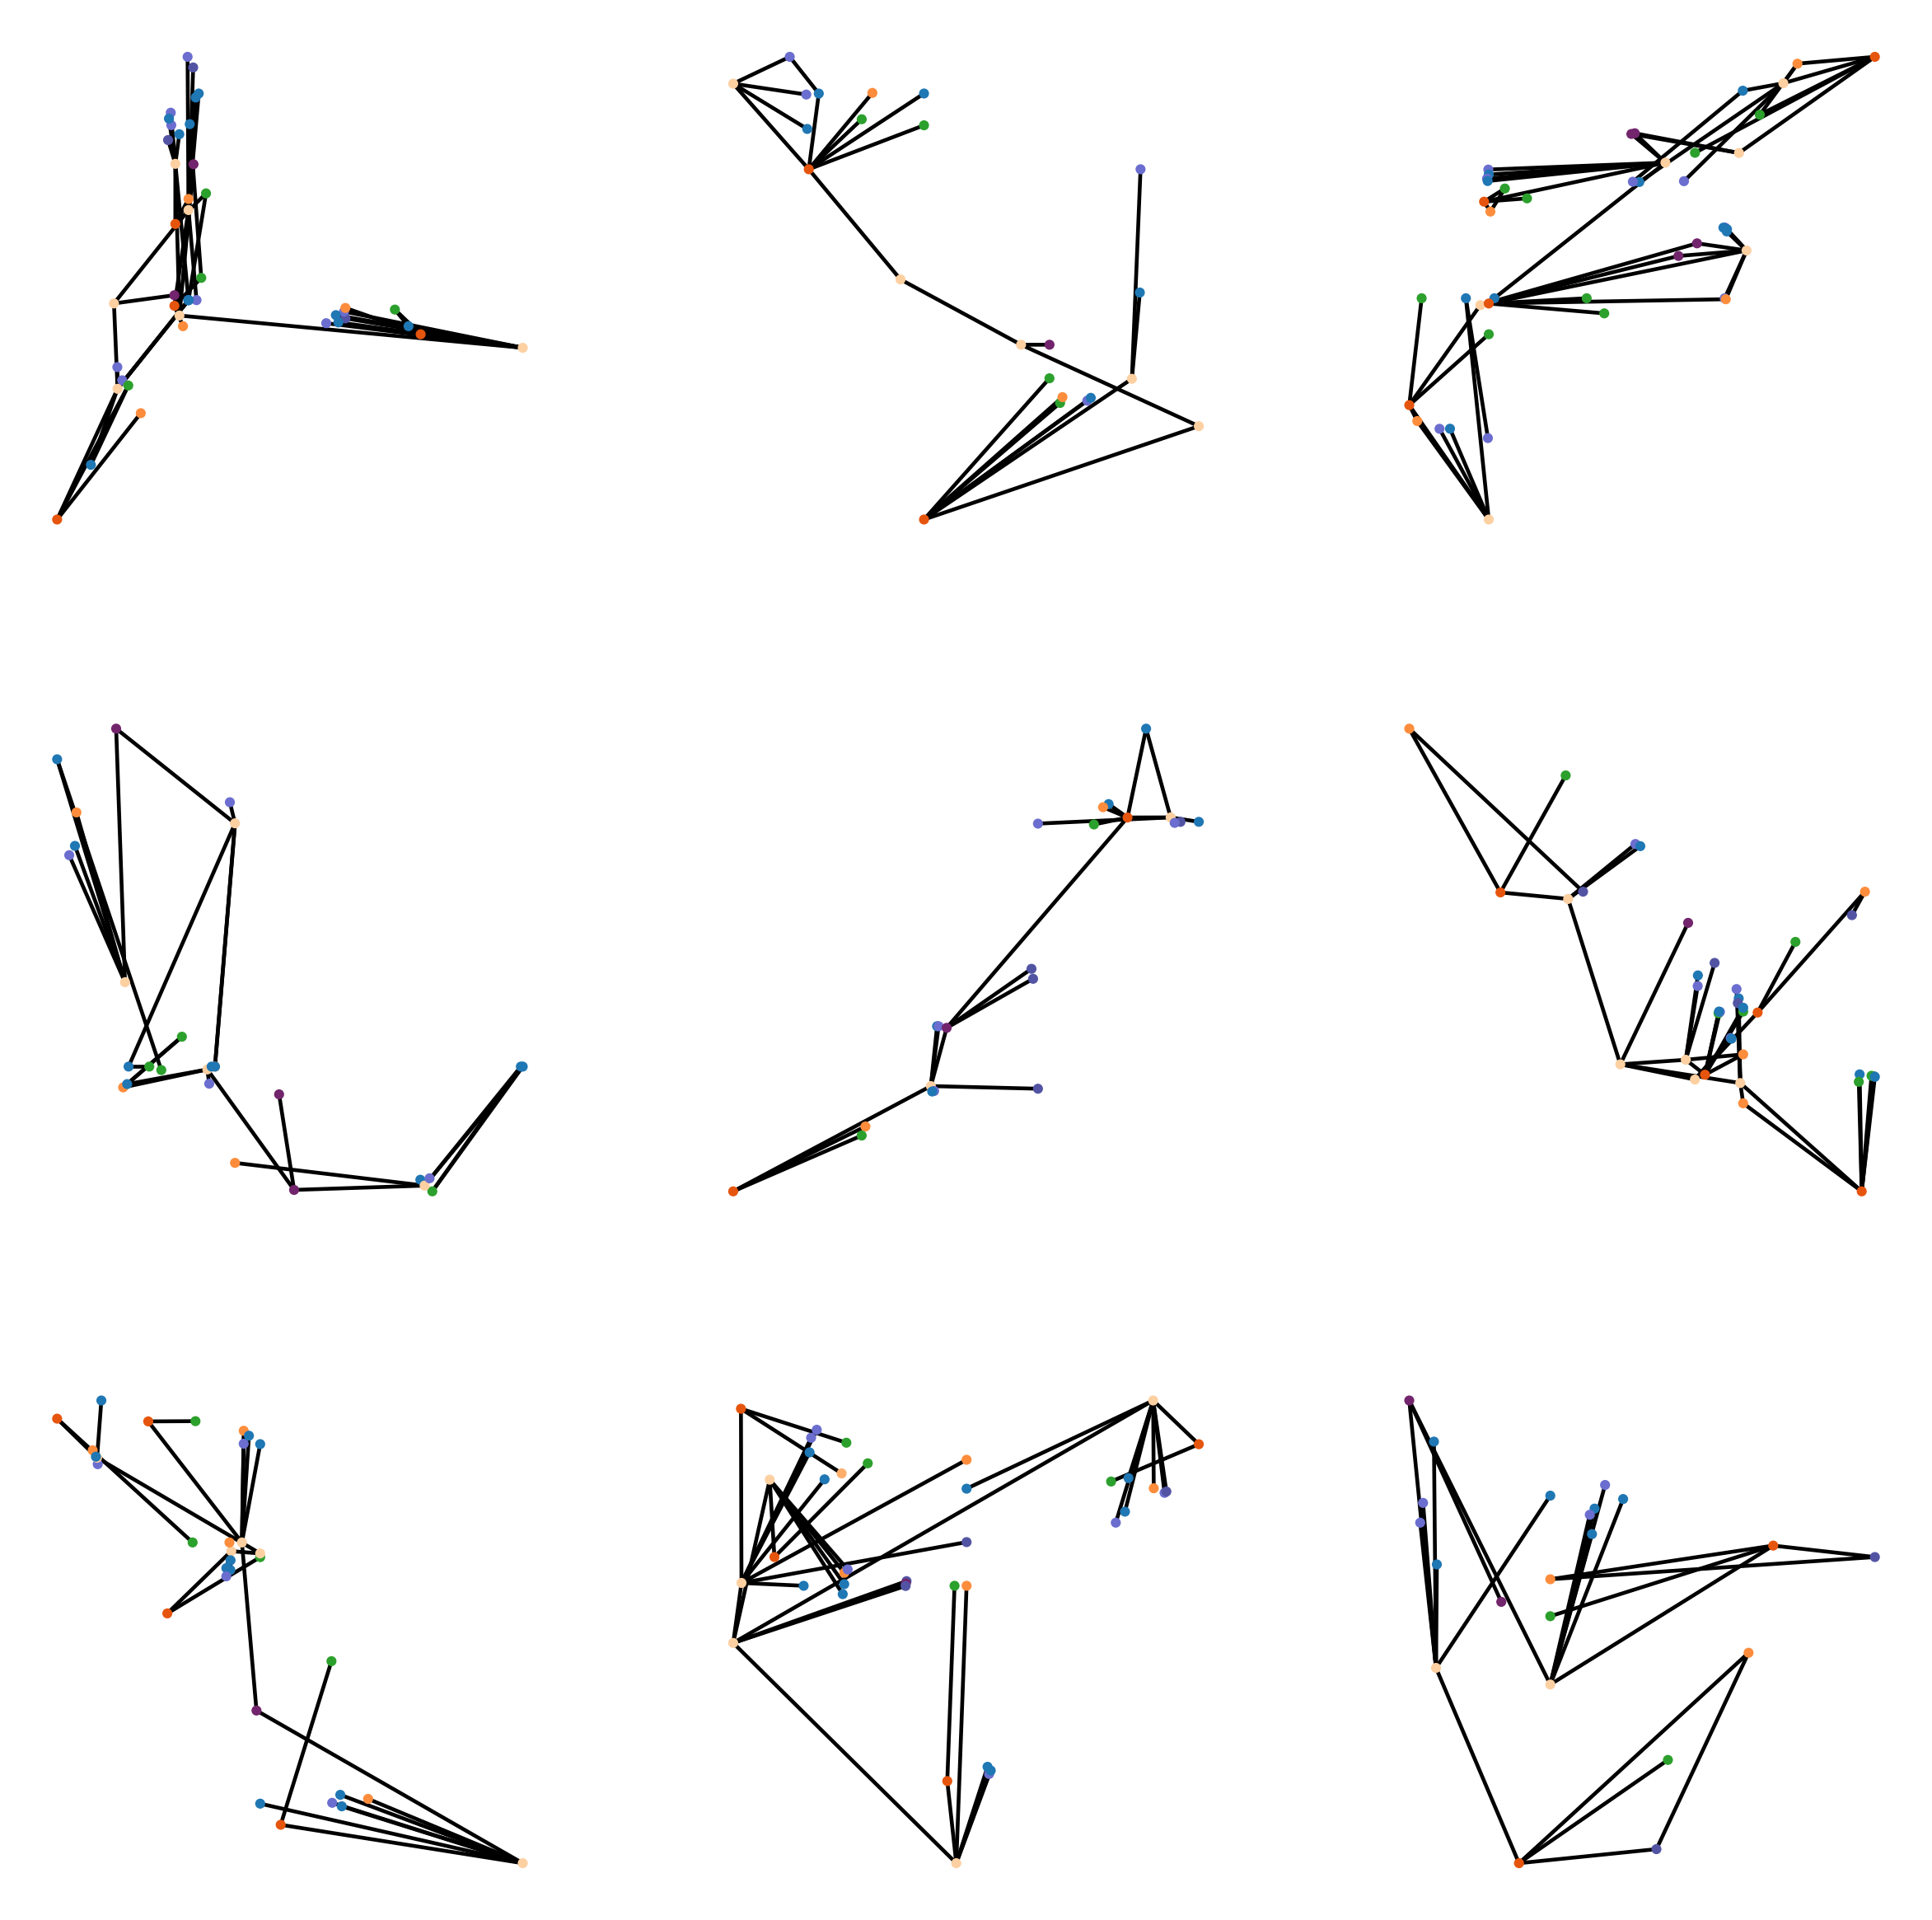

In [58]:
from plot import plot_graph

# set up figure
n = int(np.ceil(np.sqrt(bs)))
fs = 10
fig, axs = plt.subplots(n, n, figsize=(n*fs, n*fs))
axs = axs.flatten()

add = 0
for i, ax in enumerate(axs):

    nodes = torch.arange(0, data.num_nodes)[batch == i]
    graph = data_nx.subgraph(nodes.tolist())

    pos = {index+add: np.array(n) for index, n in enumerate(x_df[batch == i])}
    colors = [np.array(CMAP_ROOMTYPE(np.argmax(n))).reshape(1,4) for _, n in graph.nodes('category')]
    plot_graph(graph, ax, c_node=colors, dw_edge=False, c_edge=['black']*4, pos=pos, node_size=fs*6, edge_size=fs/3)

    add += len(nodes)

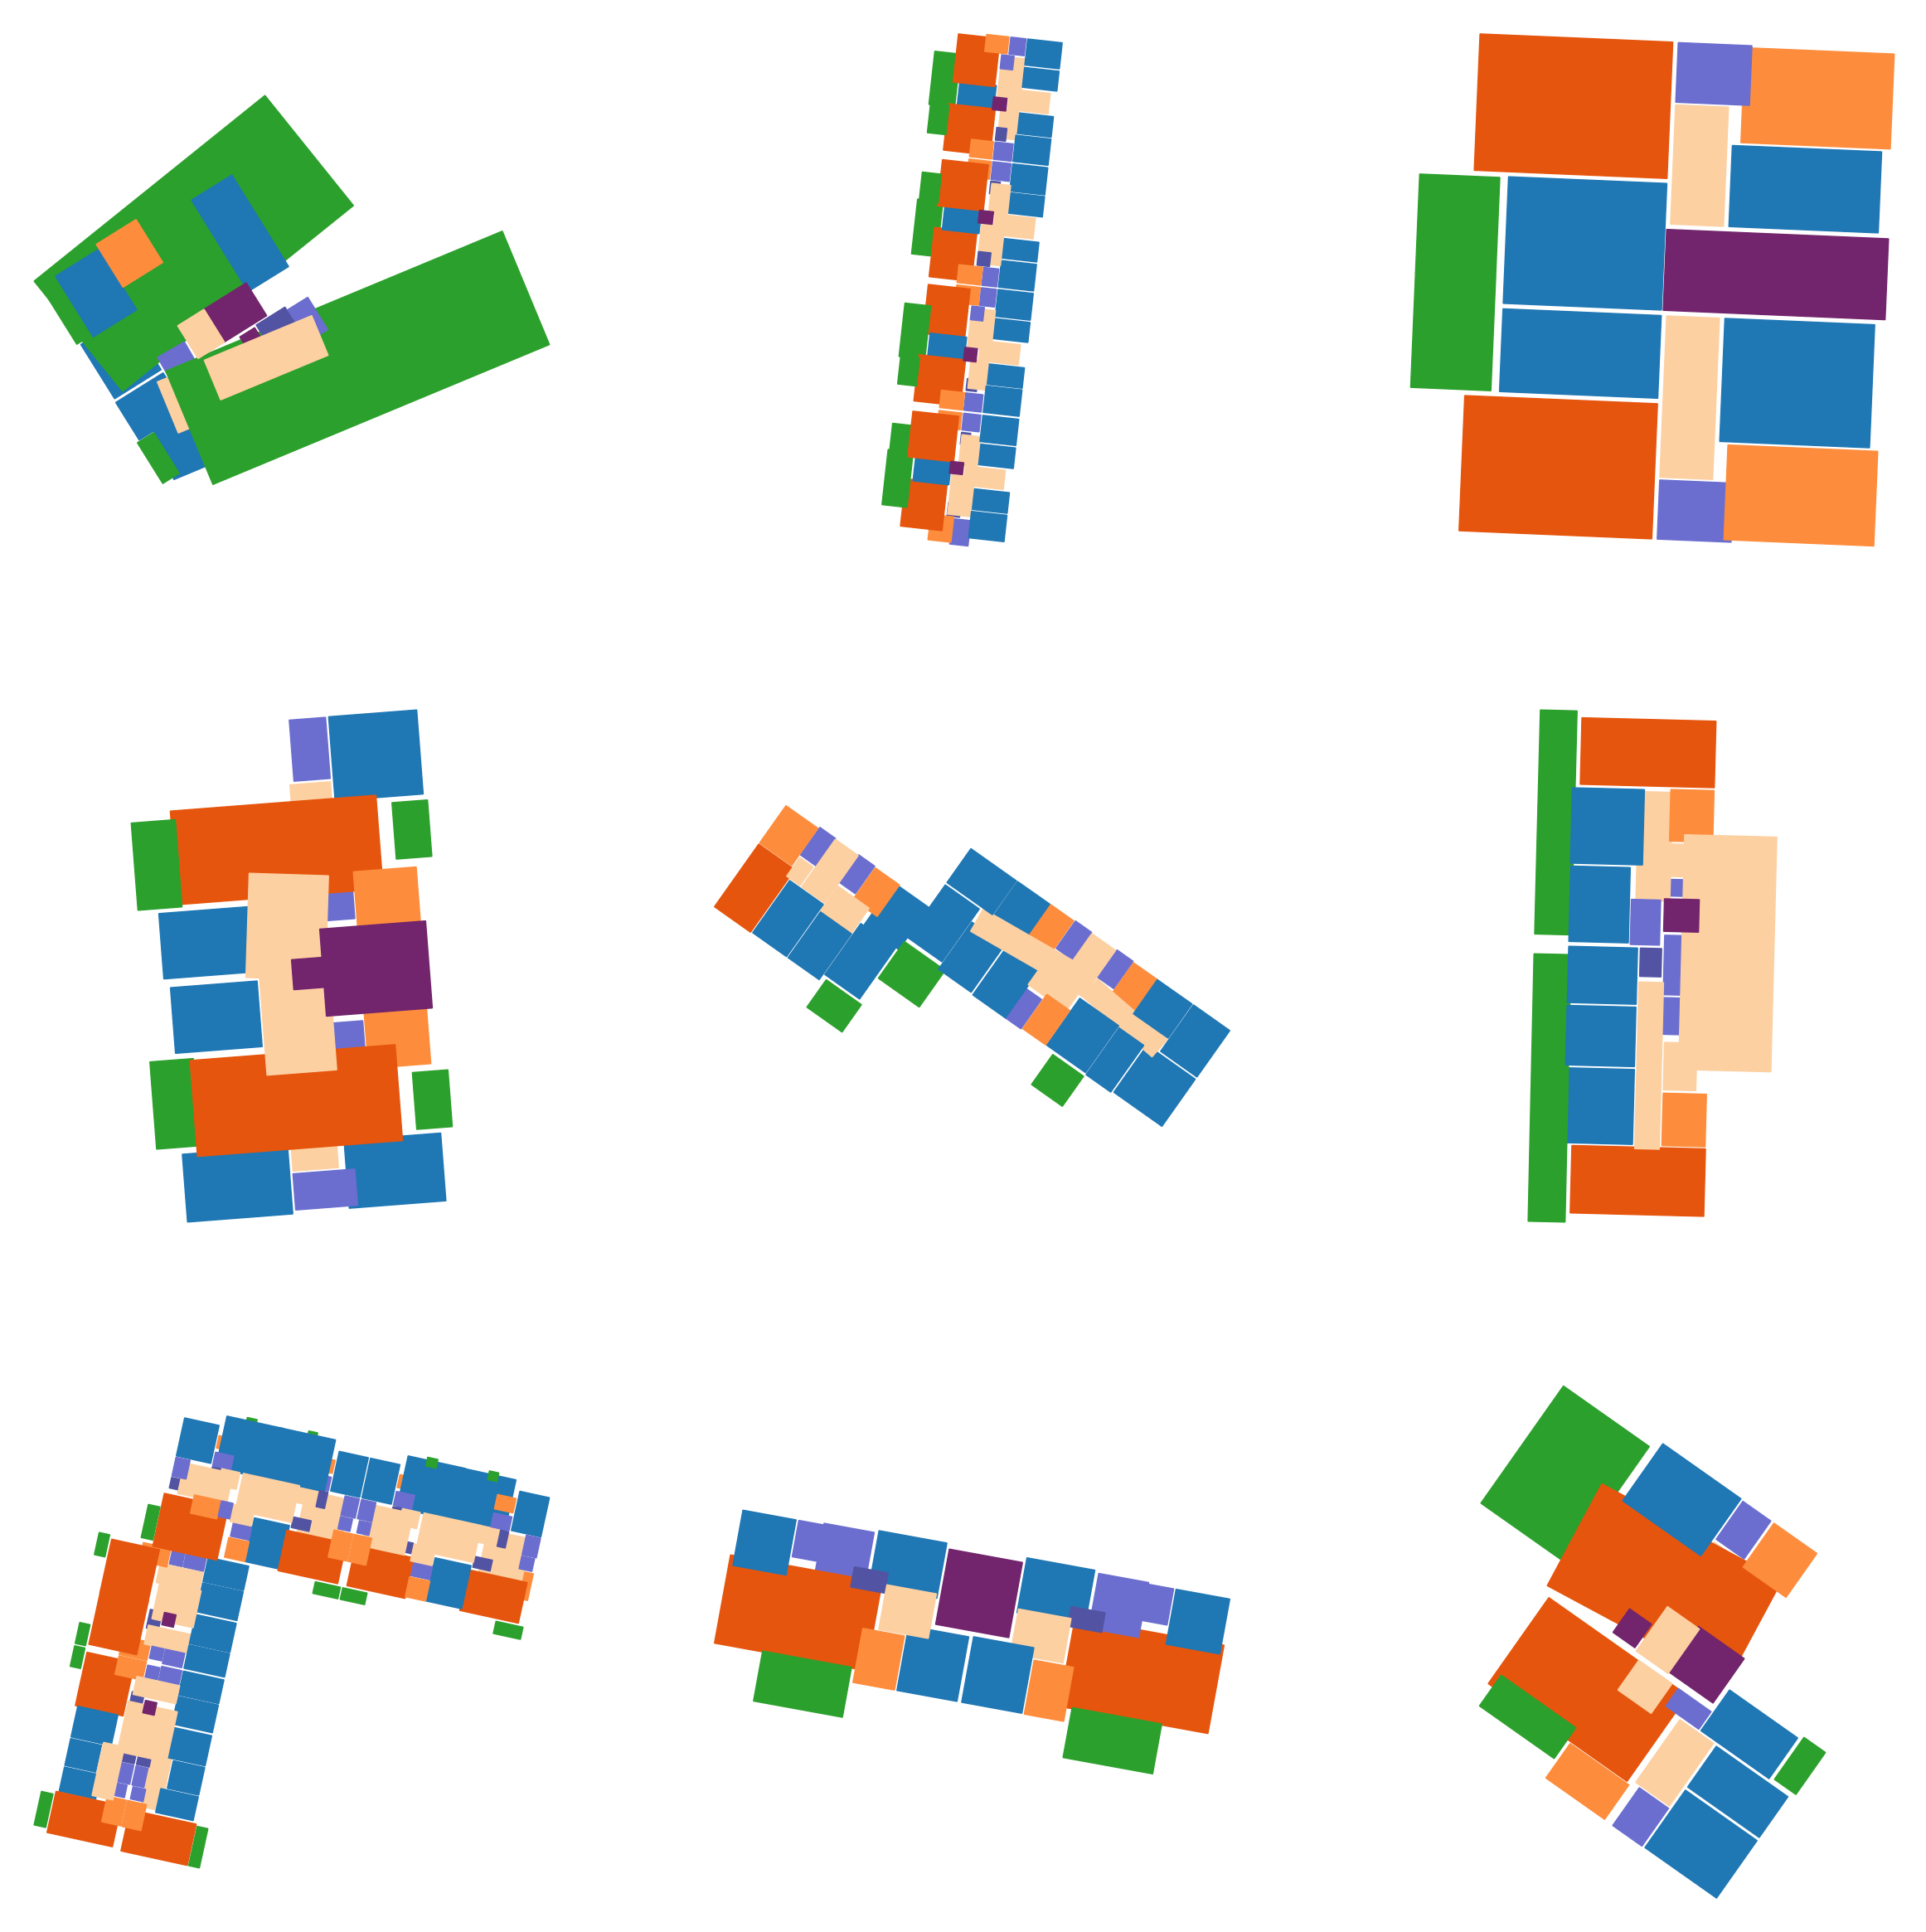

In [30]:

# set up figure
n = int(np.ceil(np.sqrt(bs)))
fs = 10
fig, axs = plt.subplots(n, n, figsize=(n*fs, n*fs))
axs = axs.flatten()

for i, ax in enumerate(axs):

    graph_pyg = torch.load(os.path.join(path["graph_simple"], f'{indices[i]}'))

    for info, roomtype in zip(graph_pyg.properties, graph_pyg.room_type):

        geom = info_to_geom(info)

        c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
        plot_polygon(ax, geom, fc=c, ec=c, label=c)

        _ = [ax.set_aspect('equal'), ax.axis('off')]